# JPEG Compression
 I will import the necessary libraries to implement and manipulate images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here is our test image and it's sahpe

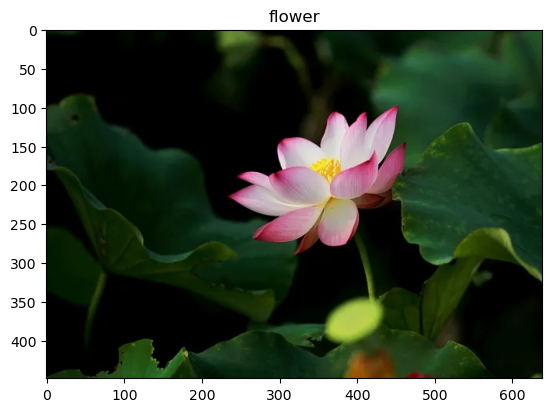

height : 449 width : 639


In [57]:
img = np.array(plt.imread("flower.webp"))
H,W = img.shape[0],img.shape[1]
plt.imshow(img)
plt.title("flower")
plt.show()
print("height : "+str(H)+" width : "+str(W))


---
## What we have ?
+ We have an image with shape **449x639x4** with **RGBA** values ranging from **0 255**
+ However since alpha value A is same for every pixel and can be represented by just 1 byte, I will ignore it and treat the image's shape as nxnxRGB meaning **449x639x3**
+ One pixel can be represented with **1 byte** or 8 bits
+ Resulting total of **860,733** bytes is needed to represent the image
> Note that this number is **hypothetical**
---
## Understanding JPEG
In JPEG a lossy compression is performed. This involves **intentional loss of data during compression**. However this lost must not effect the architecture of the image. In other words image must stay the same, **or at least it must be perceived that way.** JPEG achieve this by exploiting the weaknesses of the human eye. However what is that even mean?

There are **two kinds** of main* receptors in a human eye. **Rods** and **Cones**. Rodes are responsible of seeing in the darkness thus are more capable of sensing **brightness**. On the other hand Cones are responsible of sensing **colors**. Interestingly there are approximately **6 million Cones** and **120 million Rodes**. As a result, human eyes are **more sensitive to brightness than to color**.

**JPEG takes advantage of this property** of the human eye and uses it accordingly.This will be the first part I will be replicating.

## RGB to YCbCr

|  R    |   G      |    B   |     |
|-------|----------|--------|-----|
|0.299  |   0.587  | 0.144  | 0   |
|0.1687 |  - 0.3313|  0.5   | 128  |
|0.5    | -0.4187  |- 0.0813| 128 |

+ The Values are defined above will be the converting coefficients of RGB values to YCbCr
> Note that values are taken from the source and not experimented by myself
---
Here is the function I will be using

In [423]:
def rgb2YCbCr(tensor):
    H, W = tensor.shape[:2]
    YCbCr = np.zeros((H,W,3))
    for i in range(H):
        for j in range(W):
            YCbCr[i,j,0] =    0.299*tensor[i,j,0]  + 0.587*tensor[i,j,1]  + 0.144*tensor[i,j,2]
            YCbCr[i,j,1] = - 0.1687*tensor[i,j,0] - 0.3313*tensor[i,j,1]    + 0.5*tensor[i,j,2] + 128
            YCbCr[i,j,2] =      0.5*tensor[i,j,0] - 0.4187*tensor[i,j,1] - 0.0813*tensor[i,j,2] + 128
    return YCbCr

To visualize the Y Cb and Cr components of an image I will show a quick example of an RGB image

(321, 329, 4)


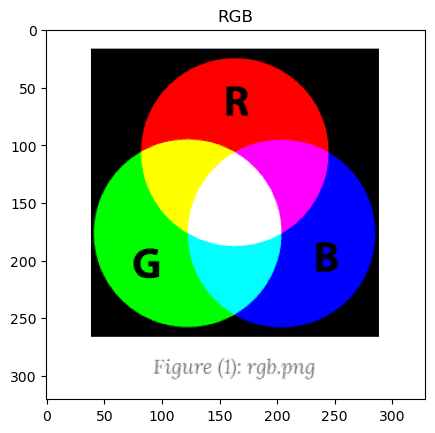

In [52]:
rgb = plt.imread("rgb.png")
plt.title("RGB")
plt.imshow(rgb)
print(rgb.shape)

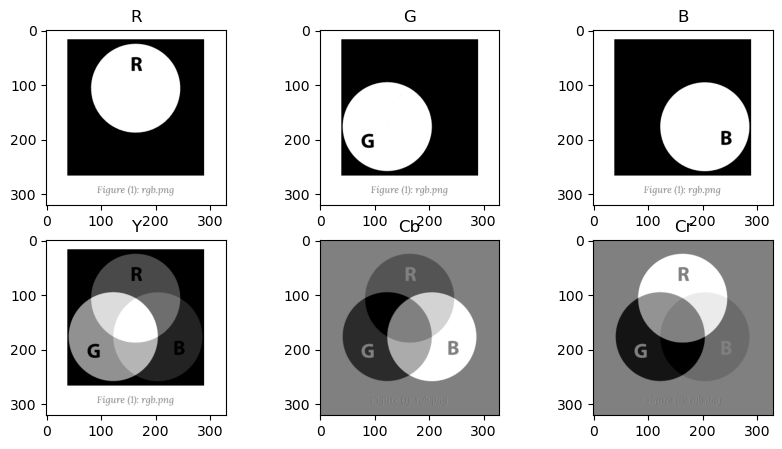

In [54]:
YCbCr = rgb2YCbCr(rgb[:,:,:3])
# Scaling the YCbCr value to 0..255
YCCmin,YCCmax = YCbCr.min(),YCbCr.max()
S_YCbCr = 255*(YCbCr-YCCmin)/(YCCmax-YCCmin)

plt.figure(figsize=(10, 5))

plt.subplot(2, 3, 1)
plt.imshow(rgb[:,:,0], cmap='gray')
plt.title('R')

plt.subplot(2, 3, 2)
plt.imshow(rgb[:,:,1], cmap='gray')
plt.title('G')

plt.subplot(2, 3, 3)
plt.imshow(rgb[:,:,2], cmap='gray')
plt.title('B')

plt.subplot(2, 3, 4)
plt.imshow(YCbCr[:,:,0], cmap='gray')
plt.title('Y')

plt.subplot(2, 3, 5)
plt.imshow(YCbCr[:,:,1], cmap='gray')
plt.title('Cb')

plt.subplot(2, 3, 6)
plt.imshow(YCbCr[:,:,2], cmap='gray')
plt.title('Cr')

plt.show()

# Reverse

After extracting the YCbCr values we need to be able to reverse the proccess and get back te original RGB values.

In [424]:
def YCbCr2rgb(tensor):
    H,W = tensor.shape[:2]
    rgb = np.zeros((H,W,3))
    for i in range(H):
        for j in range(W):
            rgb[i,j,0] = tensor[i,j,0] + 1.402*(tensor[i,j,2]-128)
            rgb[i,j,1] = tensor[i,j,0] - 0.34414*(tensor[i,j,1]-128) - 0.71414*(tensor[i,j,2]-128)
            rgb[i,j,2] = tensor[i,j,0] + 1.772*(tensor[i,j,1]-128)
    return rgb

Now to represent an image we need RGB components. Despite YCbCr values being extrcted we can't just plot them and visulize this way. Instead we will create a RGB image with **normal** values to extract the Cb and Cr components


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


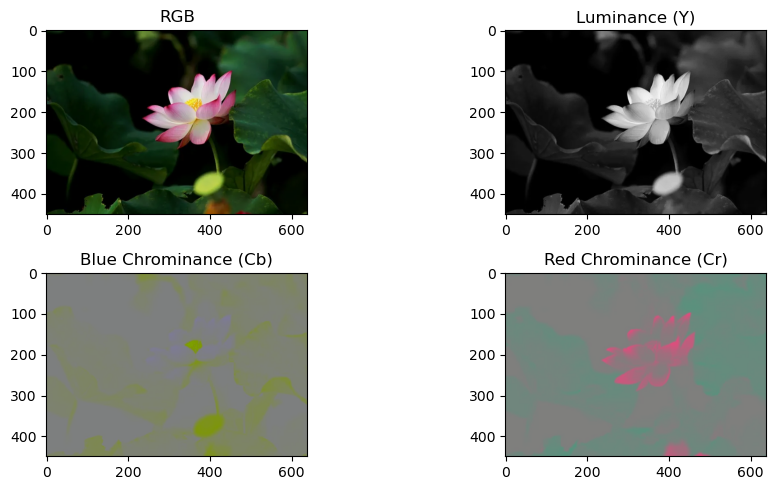

In [79]:
# Extracting the YCbCr components
YCbCr = rgb2YCbCr(flower)
H,W = YCbCr.shape[:2]
Y = YCbCr[:,:,0]
Cb = YCbCr[:,:,1]
Cr = YCbCr[:,:,2]

# Creating a normal (127) image components
z = 127 * np.ones((H, W)).astype(int)
Ysub = 127 * np.ones((H, W)).astype(int)

just_Cb = YCbCr2rgb(np.stack([Ysub, Cb, z], axis=-1)).astype(int)
just_Cr = YCbCr2rgb(np.stack([Ysub, z, Cr], axis=-1)).astype(int)

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(flower)
plt.title('RGB')

plt.subplot(2, 2, 2)
plt.imshow(Y, cmap='gray')
plt.title('Luminance (Y)')

plt.subplot(2, 2, 3)
plt.imshow(just_Cb)
plt.title('Blue Chrominance (Cb)')

plt.subplot(2, 2, 4)
plt.imshow(just_Cr)
plt.title('Red Chrominance (Cr)')

plt.tight_layout()
plt.show()

Here in the above example it's clear that the previous explanation is indeed correct. Luma image is more detaily percieved than other the Chroma images. That is **the property JPEG exploits** to reduce the size of the image.

However before that there is one more think I need to clarify.
> Since all the conversion coefficient for both forward and backward transformation are floating numbers, when an image converted from rgb to YCbCr then back to the rgb, there is expected to be an error.

# Down Sampling
Next step in JPEG algorithm is down-sampling the **Cb** and **Cr** values. There are several this can be done and I will try to demonstrate as vide as possible.

+ Firstly by down-sampling we mean taking a sample of data and reducing/collapsing it to a single pixel.
+ This step is crucial because until know we havent loss any data (if we do not count the error rate).
+ This procces will reduce the size of the data significantly.
+ Secondly we will need to determine a sample size for down-sampling or a factor.
+ Factor of 2 will collapse every 4 pixel(2x2) into one pixel. Or factor of 4 will collapse every 16(4x4) pixel into one.
+ I will demonstrate the factor of **2 , 4 , 8 , 16 , 32 , 64** for simplicity this demonstration of other than 2 factors will be just for showing the difference and will not be used later.

In [83]:
factors = [2,4,8,16,32,64]
results = [[],[],[],[],[],[]]

YCbCr = rgb2YCbCr(flower)
Y,Cb,Cr = YCbCr[:,:,0],YCbCr[:,:,1],YCbCr[:,:,2]
H,W = flower.shape[:2]
for step in range(6):
    DCb = np.zeros((H,W))
    DCr = np.zeros((H,W))
    factor = factors[step]
    for i in range(0,H,factor):
        for j in range(0,W,factor):
            x = Cb[i][j]
            y = Cr[i][j]
            for k in range(factor):
                for l in range(factor):
                    if(i+k<H and j+l<W):
                        DCb[i+k][j+l] = x
                        DCr[i+k][j+l] = y
    results[step].append(DCb)
    results[step].append(DCr)

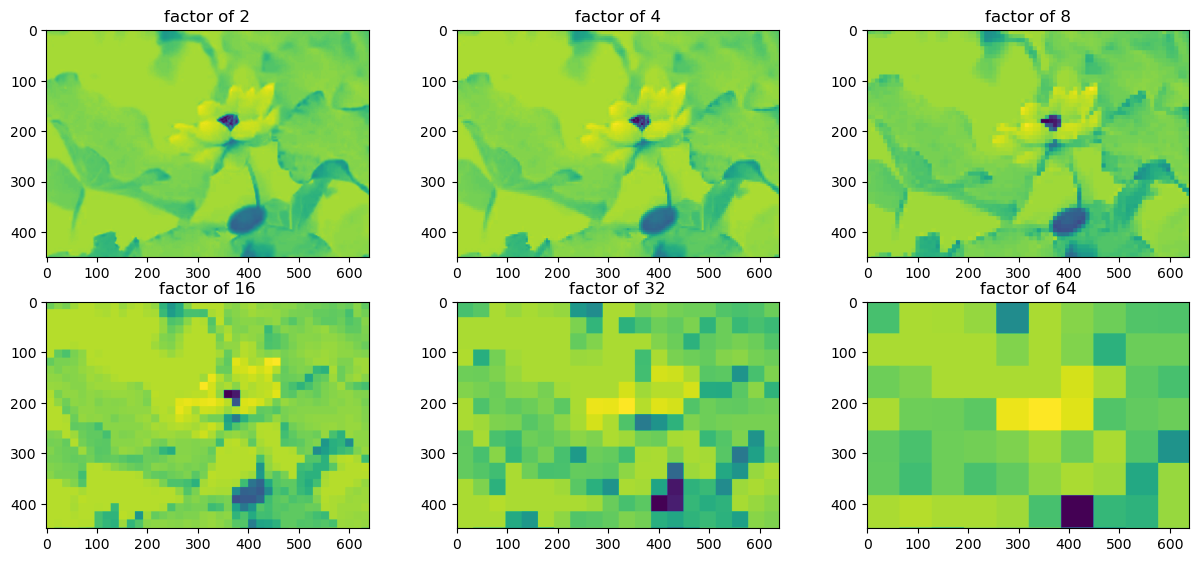

In [94]:
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.imshow(results[i][0])
    plt.title("factor of " + str(1<<(i+1)))

It can be seen from the above image how drasticly the image decate when increasing the factor by 2. However for larger shapes of images factor can be 4 or even 8.

Next step is to look how accurate our compression was we will use the factor 2,4 and 8 as well as the first Cb and Cr are values to show the difference

---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


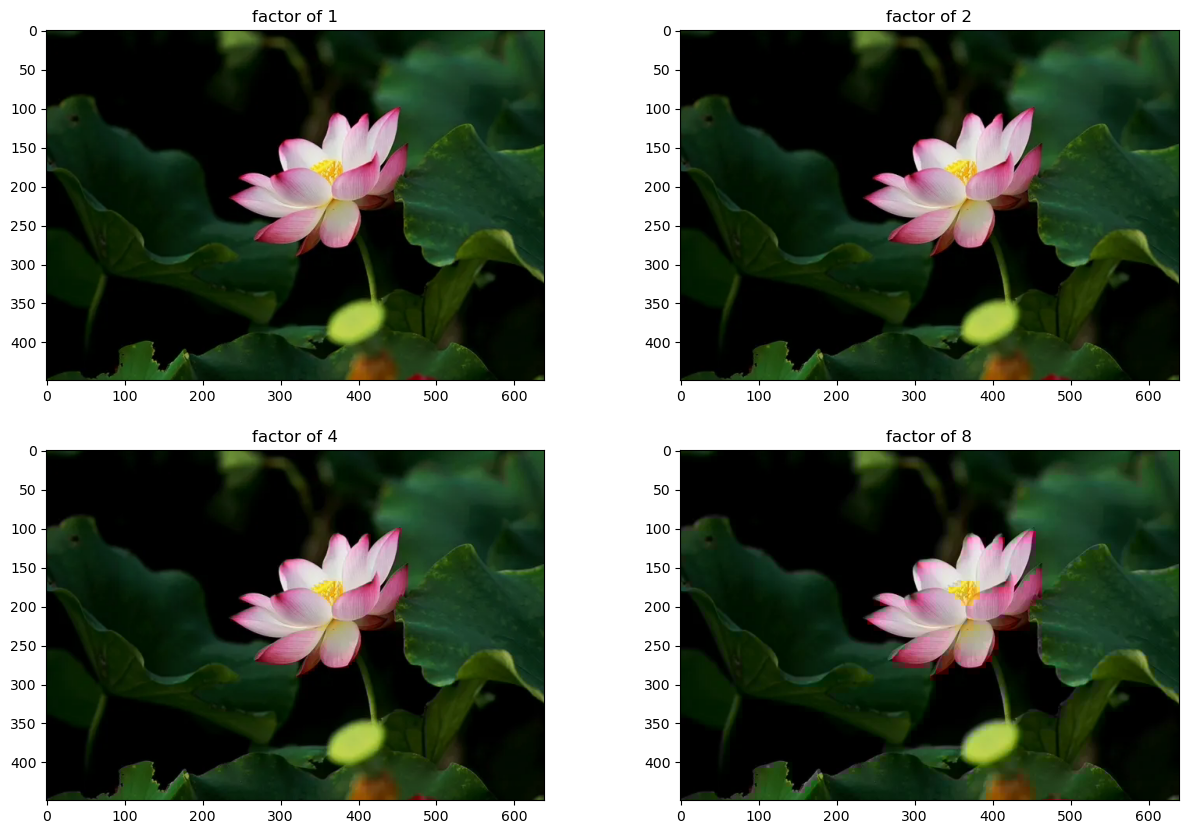

In [100]:
image_arr = [[],[],[],[]]
image_arr[0] = YCbCr2rgb(np.stack([Y, Cb,Cr], axis=-1)).astype(int)
for i in range(1,4):
    image_arr[i] = YCbCr2rgb(np.stack([Y, results[i-1][0],results[i-1][1]], axis=-1)).astype(int)
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(image_arr[i])
    plt.title("factor of " + str(1<<(i)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


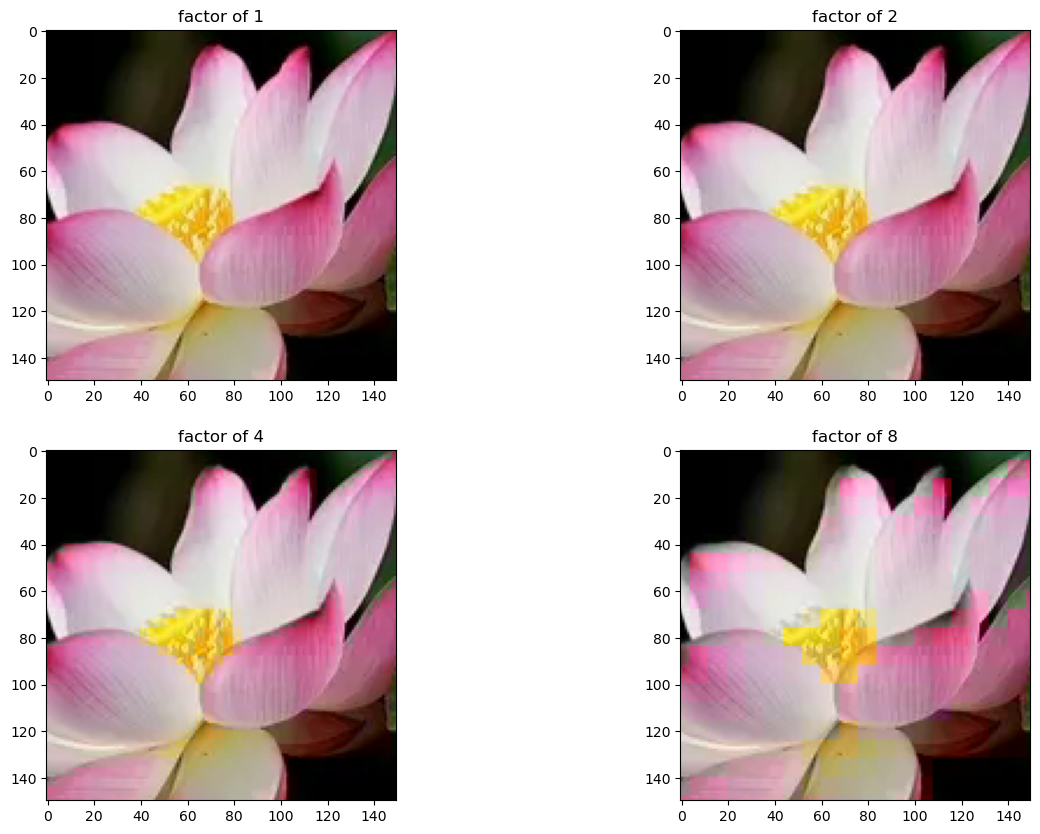

In [105]:
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(image_arr[i][100:250,300:450,:])
    plt.title("factor of " + str(1<<(i)))


As it is seen from above even though factor of 2 and 4 are not distinguishible from the original factor 8 is clearly over doned.

---
However the important point is the **original image and the factor of 2 are barerly different from each other**.
Even though we succed at contaminin the overl architecture of the image; with (1+0.25+0.25)/3 ,  we nearly reduce the image size by **half**

> I will not store the values as desired before, Cr Cb components are still the size HxW, we can reduce the size whenever we want so we will skip this step. In the end we might show the whole proccess.
---

# Forward DCT
By extracting the Y,Cb and Cr values we performed a down-sampling in order to reduce size, eventhough this procces looses data, human eye can not distinguish chroma components as much as detaily as the luma component. And we used that property to our favor.

Now third step is also crucial for reducing the data size, as well as we did before on chroma compenents there are other properties of the human eye which we can exploit in order to reduce the data size.

Human eyes tend to perceive **low frequency** components rather than **high frequencies.** This is the second propert **that JPEG exploits**. Storing high frequency datas are rather unimportant so we can do the same proccess by **extracting high and low frequencies** and reducing the size accordingly.

However for that we first need to extract the frequencies, in order to that we will use what is called **Forward DCT**

---
Forward DCT or Forward Discrete Cosine Transform is a tool which we can use to extract the frequency values.
It is the same princible as the FFT, the concept is mathematicly hard and we are only interested in the application.

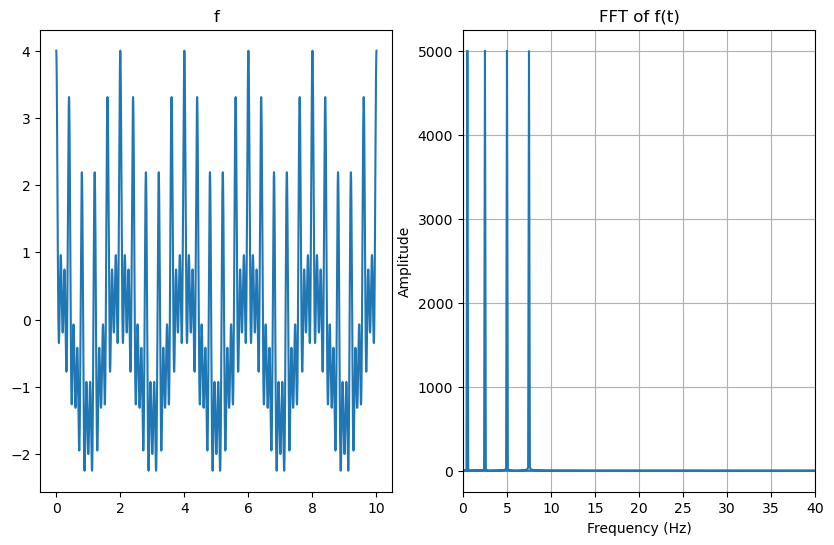

In [60]:
# Defining our function in wide range of frequencies
def f(t):
    return np.cos(np.pi*t) + np.cos(5*np.pi*t)+ np.cos(10*np.pi*t) + np.cos(15*np.pi*t)

# Generate some sample data
t = np.linspace(0, 10, 10000)  # time points
dt = t[1] - t[0]  # time step
y = f(t)  # function values

# Compute the FFT
fft_vals = np.fft.fft(y)
fft_freq = np.fft.fftfreq(len(t), dt)

# Plot
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(t,f(t))
plt.title("f")

plt.subplot(1,2,2)
plt.plot(fft_freq, np.abs(fft_vals))
plt.title('FFT of f(t)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 40)  # focusing on the region between t=2 and t=4

plt.grid(True)
plt.show()

Above a quick example of FFT since it's discreate there is expected to be an error however you can clearly see the frequency values and the magnitudes of the cos waves make up the function here's a quick backward way to get the function from frequency values.
+ frequencies = 0, 2.5, 5, 7.5 and their respective magnitudes
+ We will plot the frequencies in an increasing and cumulative order with their respective magnitudes

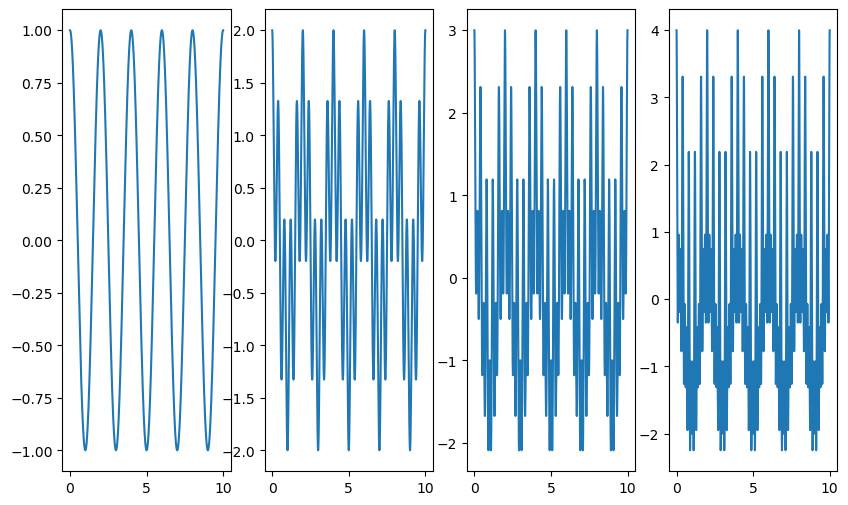

In [62]:
freq = [0.5,2.5,5,7.5]
plt.figure(figsize=(10, 6))
for i in range(4):
    f = 0
    for j in range(i+1):
        f+=np.cos(freq[j]*2*np.pi*t)
    plt.subplot(1,4,i+1)
    plt.plot(t,f)

You can see how individual frequencies cumulatively builds up the main wave. The trick here **as we go higher in the frequency we tend to detect less detail compared to lower frequencies**. In the avove example **third and fourth images** are nearly indistinguishable.

We will apply the same functionality to the images. So let's examine how and what an image builds up from.

---
# DCT Basis
For every 8x8 pixel image we will have an 64 base images made from 8x8 pixels. For every row and column frequency of the image will be increasing. Meaning **low frequency components will be in the top left corner** and **hige frequency components will be in the bottom right.**

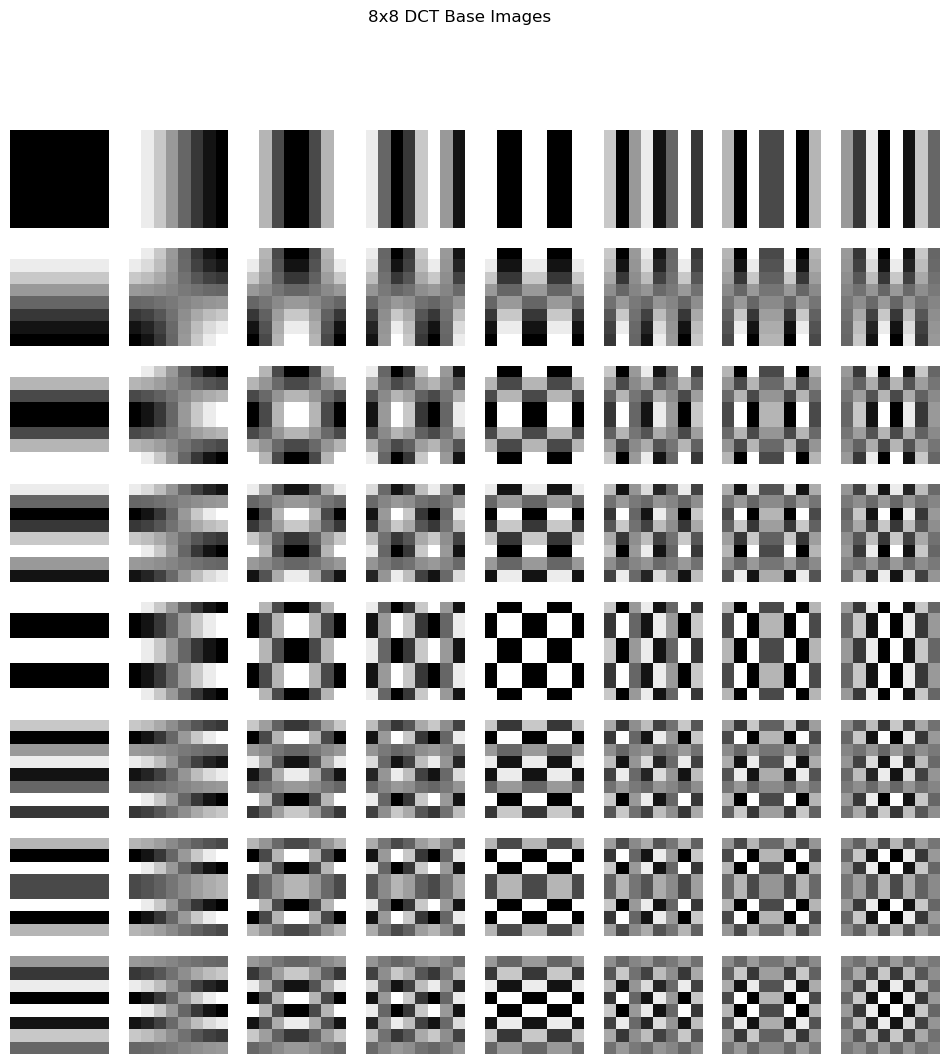

In [86]:

def generate_dct_bases(size):
    bases = np.zeros((size, size, size, size))
    for u in range(size):
        for v in range(size):
            for i in range(size):
                for j in range(size):
                    bases[u, v, i, j] = np.cos((2 * i + 1) * u * np.pi / (2 * size)) * \
                                        np.cos((2 * j + 1) * v * np.pi / (2 * size))
    return bases

def plot_dct_bases(bases):
    fig, axs = plt.subplots(8, 8, figsize=(12, 12))
    fig.suptitle('8x8 DCT Base Images')

    for u in range(8):
        for v in range(8):
            axs[u, v].imshow(bases[u, v], cmap='gray')
            axs[u, v].axis('off')

    plt.show()

# Generate and plot the 8x8 DCT base images
bases = generate_dct_bases(8)
plot_dct_bases(bases)


In the previous example we performed a FFT on a specific function and get the base frequency as well as their respective magnetidues. This time we will perfom a similar thing to get the base images and their respective magnetidues.

---
## Applying DCT
Before going through the whole image let's first work on 8x8 block so that we can get a better understanding of what is happening.

Let us define an image which we can observe and experiment on it.

Text(0.5, 1.0, 'test image')

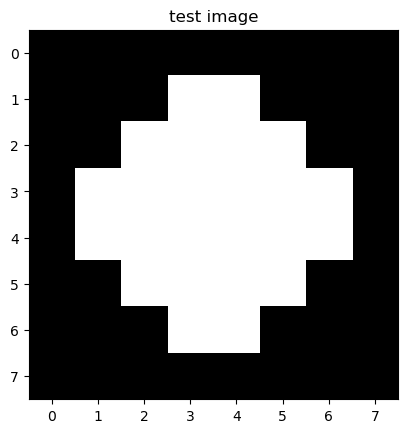

In [167]:
img = np.zeros((8,8))
for i in range(4):
    for j in range(i):
        img[i][3-j] = 255
        img[i][4+j] = 255
        img[7-i][3-j] = 255
        img[7-i][4+j] = 255
plt.imshow(img,cmap="gray")
plt.title("test image")

> To get every coefficient of the base values, we will multiply each individual value from img and the base for respective i j for every base and sum them.

Here is our equation to be exact
$$
(F)_{uv} = \Sigma_{i = 0}^{n}\ \Sigma_{j = 0}^{n}\ \frac{1}{4}\cdot C_{u}\cdot C_{v}\cdot (f)_{ij} \cdot (Base)_{ij}
| \ u,v \in 0..8
$$
$$
\ C(x) = \frac{1}{\sqrt2} \ \ if x = 0 \\
\ C(x) = 1 \ \ if \ x\neq 0
$$

max:  764.9999999999999  min:  -568.7628368338542


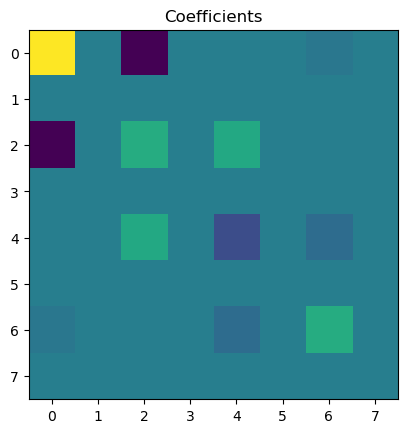

In [361]:
dct_coefficients = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        K = 1/np.sqrt(2) if i == 0 else 1
        L = 1/np.sqrt(2) if j == 0 else 1
        dct_coefficients[i,j] = K*L*np.sum(img*bases[i,j])/4
plt.imshow(dct_coefficients)
plt.title("Coefficients")
print("max: ",dct_coefficients.max()," min: ",dct_coefficients.min())

We have the coefficients in a **strange** range however this is not a concern for now. Instead we need to check if the desired coefficients are sufficiant to represent the initial image.

To do this we will simply multiply every base with it's corresponding coefficient and then sum them over in order to get the final image.

---
Here is our equation to be exact
$$
(f)_{uv} = \Sigma_{i = 0}^{n}\ \Sigma_{j = 0}^{n}\ \frac{1}{4}\cdot C_{u}\cdot C_{v}\cdot (F)_{ij} \cdot (Base)_{ij}
| \ u,v \in 0..8
$$
$$
\ C(x) = \frac{1}{\sqrt2} \ \ if x = 0 \\
\ C(x) = 1 \ \ if \ x\neq 0
$$

> Take note that both reverse and forward transition has the overall same structure

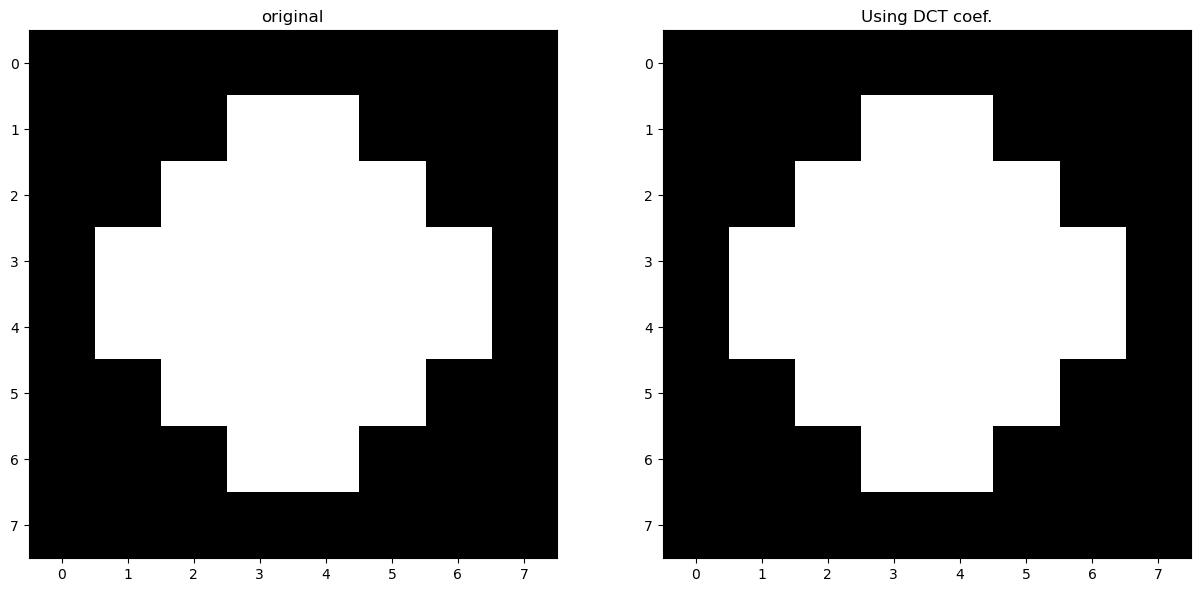

In [362]:
new_image = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        K = 1/np.sqrt(2) if i == 0 else 1
        L = 1/np.sqrt(2) if j == 0 else 1
        new_image += K*L*dct_coefficients[i,j]*bases[i,j]/4
        
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap="gray")
plt.title("original")

plt.subplot(1, 2, 2)
plt.imshow(new_image,cmap="gray")
plt.title("Using DCT coef.")

plt.show()

> Now it's important to note that even though the two images are nearly the same due to the floating points and rounding we have slight error on our values regardless of the image values and coefficients.

> Not even the range might not be stay same in the above example our new range is:

In [366]:
print("max:",new_image.max(),"min:",new_image.min())

max: 255.00000000000026 min: -9.435874847060714e-14


This would not be also a concern for us sinse we can always crop and scale the images accordingly. However we would not do that since there is no need for now.

# Quantization
Here is another crucial part. Let's say we have succesfully transform our image via DCT and we have the DCT coefficients for each of the 8x8 image for every 8x8 block of the entire image. However..
> DCT proccess does not lose any data

As the proccess explained before we will quantizize or in other words we will intentionally lose data on the way, as we did previously.

---
Here is the quantization table we are going to use:

\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
12 & 12 & 14 & 19 & 26 & 58 & 60 & 55 \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101 \\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99 \\
\end{bmatrix}

It can be seen clearly that for **high frequency coefficients we use higher quanta and for low frequency we use low quantas.**

## Before that
I want to understand I quantized matrix can protect it's owerall shape. To demonstrate this let's take a deep dive in through the DCT coefficients and the relation with the image.

---
Let us draw a line for the high frequency components 

\begin{equation*}
\begin{subarray}{l}
 \begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \\
\end{bmatrix} 
\end{subarray}
\quad
→
\begin{subarray}{l}
 \begin{bmatrix}
9 & 8 & 0 \\
6 & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix} 
\end{subarray}
\end{equation*}

By doing so we eliminate the high frequencies complietly, well of course this is not a good way to quantize the data however this will demonstrate the why the high frequency components can be tossed away.

$$
\{F(u,v) = 0\ |\ i\cdot j > k \ ,\ \forall\ i,j \in 1..8 \}
$$

$k$ will be our tool for dividing the high frequencys and low frequencies
We will be using for

$k = 64$ (original image) $k = 49$ $k = 36$ $k = 25$ $k = 16$ $k = 9$ $k = 4$ $k = 1$ 

In [410]:
Ks = [64,49,36,25,16,9,4,1]
results = []

In [411]:
for k in Ks:
    H,W = flower.shape[:2]
    H,W = (H//8)*8,(W//8)*8
    cr_flower = flower[:H,:W,0]
    cr_flower = cr_flower.copy()
    for row in range(0,H,8):
        for column in range(0,W,8):
            section = cr_flower[row:row+8,column:column+8]
            dct_coefficients = np.zeros((8,8))
            for i in range(8):
                for j in range(8):
                    K = 1/np.sqrt(2) if i == 0 else 1
                    L = 1/np.sqrt(2) if j == 0 else 1
                    dct_coefficients[i,j] = K*L*np.sum(section*bases[i,j])/4
            new_section = np.zeros((8,8))
            for i in range(8):
                for j in range(8):
                    K = 1/np.sqrt(2) if i == 0 else 1
                    L = 1/np.sqrt(2) if j == 0 else 1
                    if ((i+1)*(j+1)>k): K = 0
                    new_section += K*L*dct_coefficients[i,j]*bases[i,j]/4
            for i in range(8):
                for j in range(8):
                    cr_flower[row+i][column+j] = new_section[i][j]
    results.append(cr_flower)

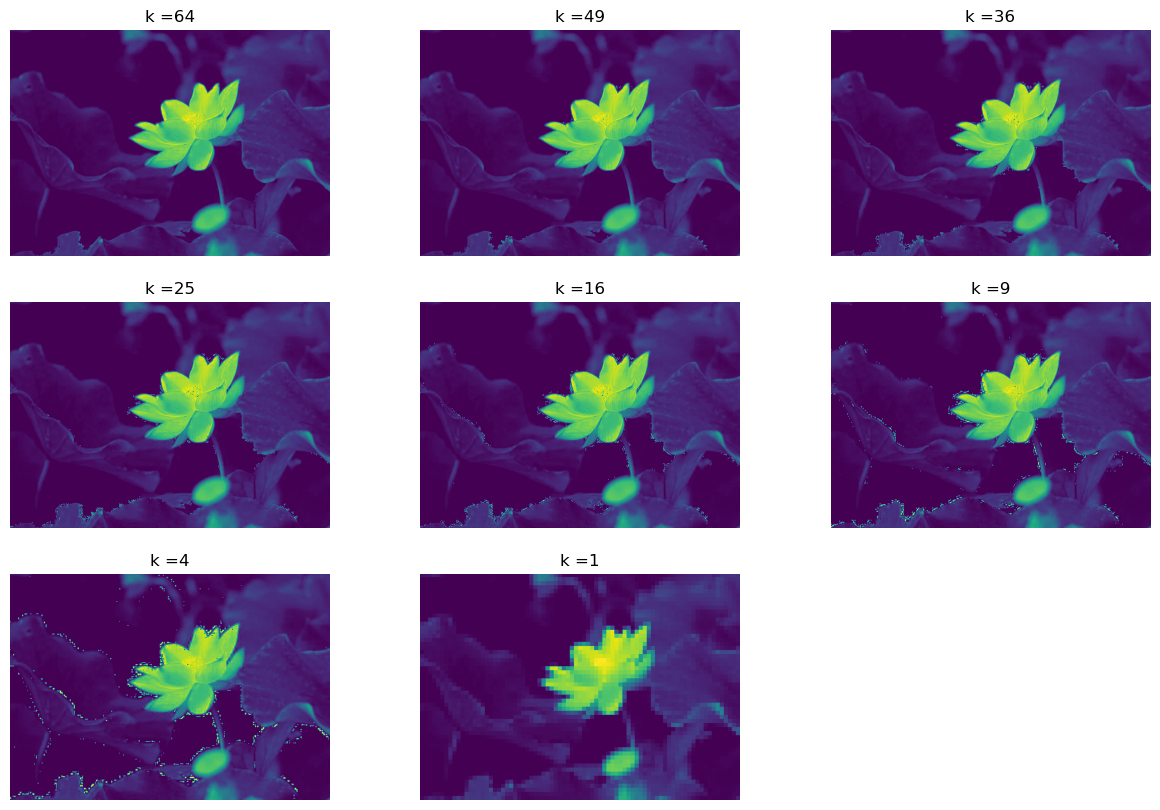

In [414]:
plt.figure(figsize=(15,10))
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.imshow(results[i])
    plt.axis('off')
    plt.title("k ="+str(Ks[i]))

Here is the dramatic outcome of the **high frequencies** as you can see, until $k = 9$ we **can't even distinguish** the image from the original. Actually for $k = 4$ we only use $8$ of the $64$ bases and even we can still see the details, as well as some corruption.

---
This is the real power we can use in order to compress our three image components Luma Cb and Cr. Even though we mostly focues on the luma component we can still do the same procces for the Chroma components.

---
> For the note I will not cover the exact table of quantization for know since we are only interested in getting a general understanding of the procces.
---
## Putting all together
For recalling all the procces here's our steps from the beginning:


In [466]:
factors = [2,4]
Cresults = [[],[]]
flower = plt.imread("flower.webp")
YCbCr = rgb2YCbCr(flower)
Y,Cb,Cr = YCbCr[:,:,0],YCbCr[:,:,1],YCbCr[:,:,2]
H,W = flower.shape[:2]
for step in range(2):
    DCb = np.zeros((H,W))
    DCr = np.zeros((H,W))
    factor = factors[step]
    for i in range(0,H,factor):
        for j in range(0,W,factor):
            x = Cb[i][j]
            y = Cr[i][j]
            for k in range(factor):
                for l in range(factor):
                    if(i+k<H and j+l<W):
                        DCb[i+k][j+l] = x
                        DCr[i+k][j+l] = y
    Cresults[step].append(DCb)
    Cresults[step].append(DCr)



In [469]:
IMG = []
Ks = [36,16]
for C in Cresults:
    for k in Ks:
        YCbCr = np.stack([Y,C[0],C[1]], axis=-1)
        RES = []
        k = 49
        for i in range(3):
            H,W = YCbCr.shape[:2]
            H,W = (H//8)*8,(W//8)*8
            cr_flower = YCbCr[:H,:W,i]
            cr_flower = cr_flower.copy()
            for row in range(0,H,8):
                for column in range(0,W,8):
                    section = cr_flower[row:row+8,column:column+8]
                    dct_coefficients = np.zeros((8,8))
                    for i in range(8):
                        for j in range(8):
                            K = 1/np.sqrt(2) if i == 0 else 1
                            L = 1/np.sqrt(2) if j == 0 else 1
                            dct_coefficients[i,j] = K*L*np.sum(section*bases[i,j])/4
                    new_section = np.zeros((8,8))
                    for i in range(8):
                        for j in range(8):
                            K = 1/np.sqrt(2) if i == 0 else 1
                            L = 1/np.sqrt(2) if j == 0 else 1
                            if ((i+1)*(j+1)>k): K = 0
                            new_section += K*L*dct_coefficients[i,j]*bases[i,j]/4
                    for i in range(8):
                        for j in range(8):
                            cr_flower[row+i][column+j] = new_section[i][j]
            RES.append(cr_flower)
        IMG.append(RES)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


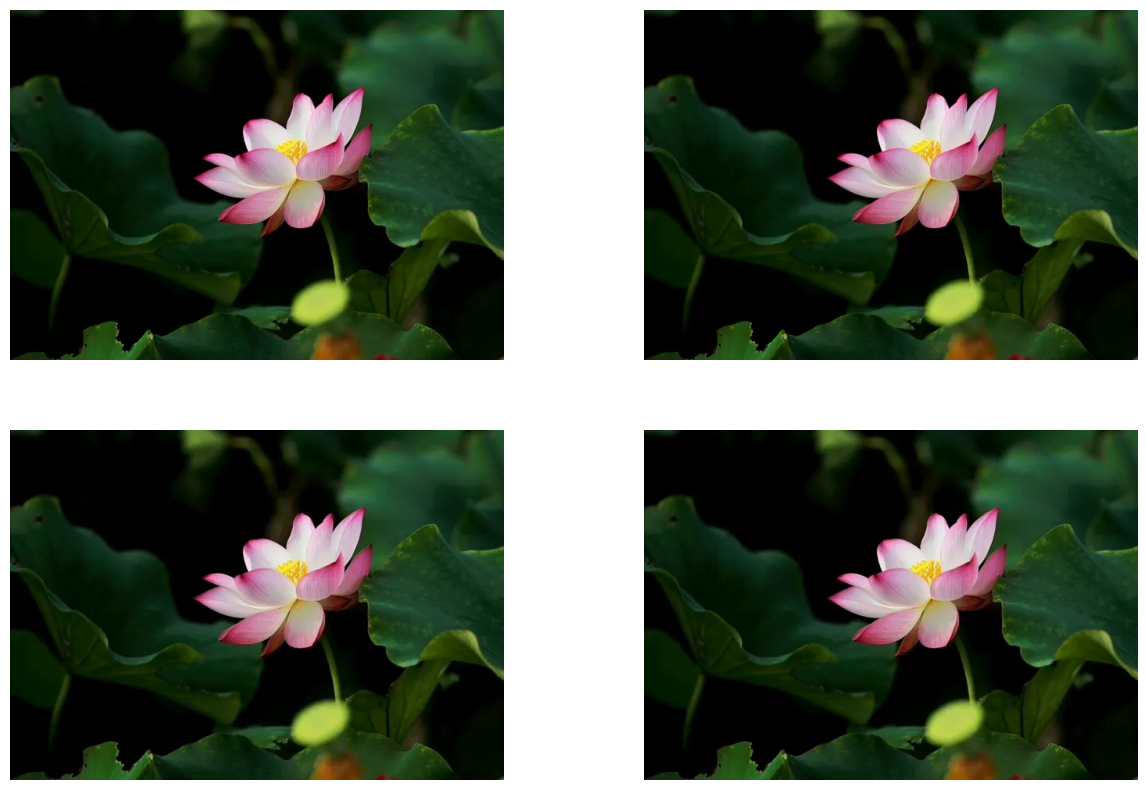

In [478]:
plt.figure(figsize=(15,10))
for i in range(4):
    image_plt = YCbCr2rgb(np.stack([IMG[i][0],IMG[i][1],IMG[i][2]], axis=-1)).astype(int)
    plt.subplot(2,2,i+1)
    plt.imshow(image_plt)
    plt.axis('off')

The images (k,factor for downsampling) respectivly :
\begin{bmatrix}
2,36 & 2,16 \\
4,36 & 4,16 \\
\end{bmatrix}
> As it's seen the right bottom image is the most corrupted while top left image is still protects the architecture and the color scheme

---
However for $k = 16$ and factor of $2$ we can see that we can't see any difference at all. And astonishingly we succeed to compress the image to it's orignal size's $\%30$.

In the beginning we stated the number of bytes to store the image was **860,733** and now it's **301,256 bytes.**

> I will continue this with using the real quanta table and adding extra zig-zag coding however this is for enough the understand the general structure of the JPEG

> I also want to create a compleate python script for this job and use it on a website so it can accessible from anywhere.